In [0]:
# hw11 
# build the AVE and linear interpolates in two 7 space.

In [0]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm

import keras 
from keras import backend as K
from keras import layers
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.utils import to_categorical

%matplotlib inline
  

In [0]:
# True if pre-trained weights for the VAEs shall be
# loaded, False for training the VAEs from scratch.
use_pretrained = True

latent_dim = 5
# Dimensions of MNIST images  
image_shape = (28, 28, 1)

 
# Mini-batch size for training
batch_size = 128

def create_encoder():
    '''
    Creates a convolutional encoder model for MNIST images.
    
    - Input for the created model are MNIST images. 
    - Output of the created model are the sufficient statistics
      of the variational distriution q(t|x;phi), mean and log 
      variance. 
    '''
    encoder_iput = layers.Input(shape=image_shape)
    
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(encoder_iput)
    x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(32, activation='relu')(x)

    t_mean = layers.Dense(latent_dim)(x)
    t_log_var = layers.Dense(latent_dim)(x)

    return Model(encoder_iput, [t_mean, t_log_var], name='encoder')

def create_decoder():
    '''
    Creates a (de-)convolutional decoder model for MNIST images.
    
    - Input for the created model are latent vectors t.
    - Output of the model are images of shape (28, 28, 1) where
      the value of each pixel is the probability of being white.
    '''
    decoder_input = layers.Input(shape=(latent_dim,))
    
    x = layers.Dense(12544, activation='relu')(decoder_input)
    x = layers.Reshape((14, 14, 64))(x)
    x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
    x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)
    
    return Model(decoder_input, x, name='decoder')

In [0]:
def sample(args):
    '''
    Draws samples from a standard normal and scales the samples with
    standard deviation of the variational distribution and shifts them
    by the mean.

    '''
    t_mean, t_log_var = args
    t_sigma = K.sqrt(K.exp(t_log_var))
    epsilon = K.random_normal(shape=K.shape(t_mean), mean=0., stddev=1.)
    return t_mean + t_sigma * epsilon

def create_sampler():
    '''
    Creates a sampling layer.
    '''
    return layers.Lambda(sample, name='sampler')

In [0]:
encoder = create_encoder()
decoder = create_decoder()
sampler = create_sampler()

x = layers.Input(shape=image_shape)
t_mean, t_log_var = encoder(x)
t = sampler([t_mean, t_log_var])
t_decoded = decoder(t)

vae = Model(x, t_decoded, name='vae')

In [0]:
def neg_variational_lower_bound(x, t_decoded):
    '''
    Negative variational lower bound used as loss function
    for training the variational auto-encoder.
    
    Args:
        x: input images
        t_decoded: reconstructed images
    '''
    # Reconstruction loss
    rc_loss = K.sum(K.binary_crossentropy(
        K.batch_flatten(x), 
        K.batch_flatten(t_decoded)), axis=-1)

    # Regularization term (KL divergence)
    kl_loss = -0.5 * K.sum(1 + t_log_var \
                             - K.square(t_mean) \
                             - K.exp(t_log_var), axis=-1)
    
    # Average over mini-batch
    return K.mean(rc_loss + kl_loss)

In [28]:
# MNIST training and validation data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))

x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

# Compile variational auto-encoder model
vae.compile(optimizer='rmsprop', loss=neg_variational_lower_bound)

# Train variational auto-encoder with MNIST images
vae.fit(x=x_train, 
         y=x_train,
         epochs=25,
         shuffle=True,
         batch_size=batch_size,
         validation_data=(x_test, x_test), verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
 - 15s - loss: 185.5073 - val_loss: 148.1511
Epoch 2/25
 - 14s - loss: 141.4262 - val_loss: 135.3251
Epoch 3/25
 - 14s - loss: 134.6442 - val_loss: 130.5695
Epoch 4/25
 - 14s - loss: 131.2259 - val_loss: 129.0502
Epoch 5/25
 - 14s - loss: 128.9198 - val_loss: 127.3522
Epoch 6/25
 - 14s - loss: 127.1827 - val_loss: 124.8158
Epoch 7/25
 - 14s - loss: 125.7896 - val_loss: 124.3814
Epoch 8/25
 - 14s - loss: 124.5896 - val_loss: 123.0947
Epoch 9/25
 - 14s - loss: 123.6663 - val_loss: 123.2763
Epoch 10/25
 - 14s - loss: 122.8030 - val_loss: 122.8714
Epoch 11/25
 - 14s - loss: 122.1056 - val_loss: 121.0888
Epoch 12/25
 - 14s - loss: 121.4644 - val_loss: 121.7073
Epoch 13/25
 - 14s - loss: 120.8529 - val_loss: 123.1961
Epoch 14/25
 - 14s - loss: 120.3881 - val_loss: 120.1387
Epoch 15/25
 - 14s - loss: 119.9308 - val_loss: 121.0967
Epoch 16/25
 - 14s - loss: 119.5086 - val_loss: 121.2668
Epoch 17/25
 - 14s - loss: 119.1176 - val_loss:

In [0]:
from keras import *
 
def encode(model, images):
    '''Encodes images with the encoder of the given auto-encoder model'''
    return model.get_layer('encoder').predict(images)[0]


def decode(model, codes):
    '''Decodes latent vectors with the decoder of the given auto-encoder model'''
    return model.get_layer('decoder').predict(codes)


def encode_decode(model, images):
    '''Encodes and decodes an image with the given auto-encoder model'''
    return decode(model, encode(model, images))


if use_pretrained:
    # Manually selected indices corresponding to digits 0-9 in the test set
    selected_idx = [5531, 2553, 1432, 4526, 9960, 6860, 6987, 3720, 5003, 9472]
else:
    # Randomly selected indices 
    selected_idx = np.random.choice(range(x_test.shape[0]), 10, replace=False)

selected = x_test[selected_idx]
selected_dec_vae = encode_decode(vae, selected) 

# plot_image_rows([selected, selected_dec_vae   ], 
#                 ['Original images', 
#                  'Images generated by plain VAE' ])

In [0]:
import numpy as np

def linear_interpolation(model, x_from, x_to, steps=10):
    n = steps + 1

    t_from = encode(model, np.array([x_from]))[0]
    t_to = encode(model, np.array([x_to]))[0]

    diff = t_to - t_from
    inter = np.zeros((n, t_from.shape[0]))
    for i in range(n):
        inter[i] = t_from + i / steps * diff

    return decode(model, inter)

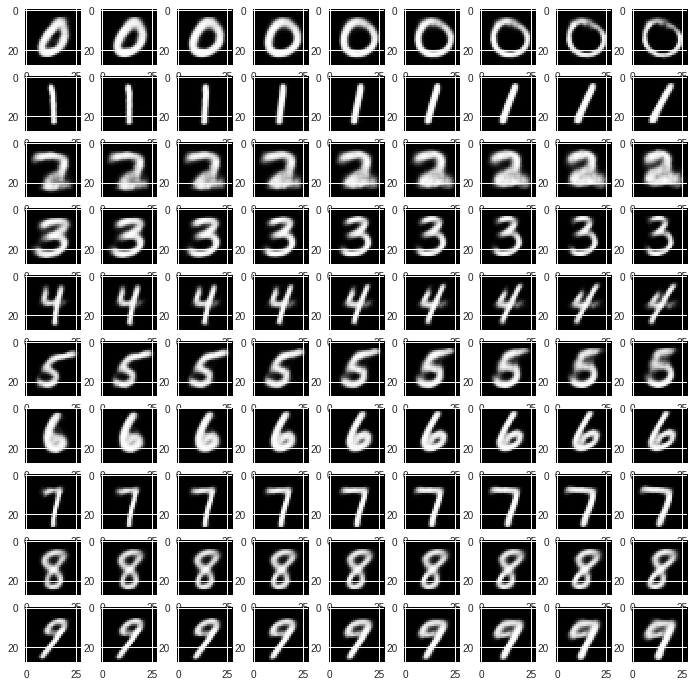

In [31]:
plt.figure(figsize=(12,12)) 

for i in range(10):
    img1 = np.reshape(x_train[y_train==i][3:4],(28,28,1))
    img2 =np.reshape(x_train[y_train==i][7:8],(28,28,1))
    tmp = linear_interpolation(vae,img1, img2, steps=8) 
    for j in range(9):
        plt.subplot(10,9,(j+1+9*(i))) 
        plt.imshow(np.reshape(tmp[j], (28, 28)),cmap = 'gray')  


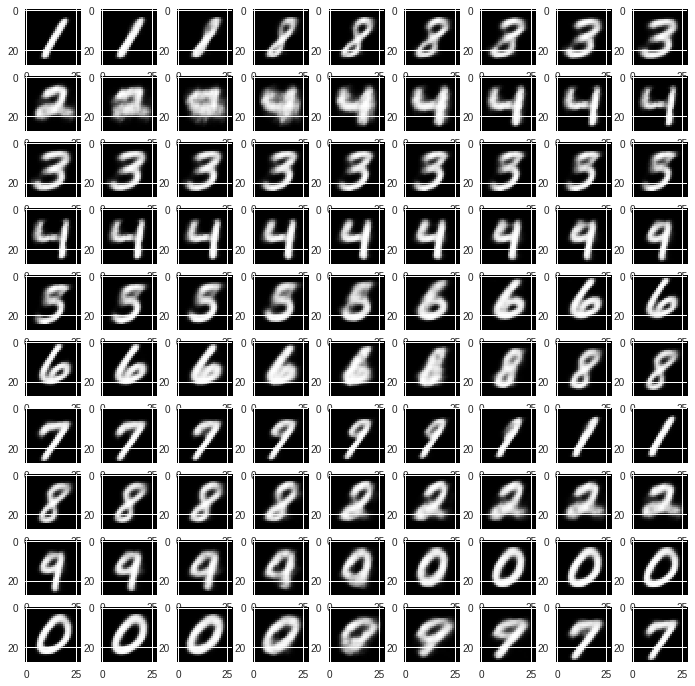

In [81]:
import random

ind = []
for i in range(10):
  ind.append(list(y_train).index(i))
  
idx1= [1,2,3,4,5,6,7,8,9,0]
idx2= [3,4,5,9,6,8,1,2,0,7]
plt.figure(figsize=(12,12)) 

for i in range(10):
  idx = random.sample(ind, 2)

  
  img1 = np.reshape(x_train[ind[idx1[i]]],(28,28,1))
  img2 = np.reshape(x_train[ind[idx2[i]]],(28,28,1))
  tmp = linear_interpolation(vae,img1, img2, steps=8) 
  for j in range(9):
      plt.subplot(10,9,(j+1+9*(i))) 
      plt.imshow(np.reshape(tmp[j], (28, 28)),cmap = 'gray')  
